In [1]:
%matplotlib inline
%reload_ext autoreload

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

FORMAT = "%(asctime)s %(message)s"

logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")
sns.set_context("talk")

In [3]:
epoch_key = 'Jaq', 3, 12

In [4]:
from src.load_data import load_data


data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=30,
                 min_distance_traveled=50,
                 )

18-Feb-22 09:50:00 Loading position info...
18-Feb-22 09:50:53 Loading multiunit...
18-Feb-22 09:51:13 Loading spikes...
18-Feb-22 09:51:20 Finding ripple times...


In [5]:
import numpy as np

detector_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'spike_model_knot_spacing': 8.0,
    'spike_model_penalty': 1E-5,
    'movement_state_transition_type': 'random_walk',
    'multiunit_model_kwargs': {
        'mark_std': 20.0, 'position_std': 8.0, 'block_size': 100},
    'discrete_state_transition_type': 'constant',
    'discrete_diagonal': np.array([0.00003, 0.968])
}

In [12]:
np.asarray([[1 - detector_parameters['discrete_diagonal'][0], detector_parameters['discrete_diagonal'][0]],
            [1 - detector_parameters['discrete_diagonal'][1], detector_parameters['discrete_diagonal'][1]]])

array([[9.9997e-01, 3.0000e-05],
       [3.2000e-02, 9.6800e-01]])

In [6]:
from replay_identification import ReplayDetector
from src.parameters import WTRACK_EDGE_ORDER, WTRACK_EDGE_SPACING


replay_detector = ReplayDetector(**detector_parameters)
logging.info(replay_detector)

replay_detector.fit(
    is_ripple=data['is_ripple'],
    is_training=np.ones_like(data['position_info'].linear_position).squeeze(),
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    track_graph=data['track_graph'],
    edge_order=WTRACK_EDGE_ORDER,
    edge_spacing=WTRACK_EDGE_SPACING,
    use_gpu=True,
)

results = replay_detector.predict(
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    time=data['position_info'].index / np.timedelta64(1, 's'),
    use_likelihoods=['spikes'],
    use_acausal=True,
    set_no_spike_to_equally_likely=True,
    use_gpu=False,
)
logging.info('Done!')

18-Feb-22 10:39:44 ReplayDetector(discrete_diagonal=array([3.00e-05, 9.68e-01]),
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=6...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 20.0,
                                       'position_std': 8.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.5, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_mode

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

18-Feb-22 10:51:19 Finding causal non-local probability and position...
18-Feb-22 10:51:29 Finding acausal non-local probability and position...
18-Feb-22 10:52:00 Done!


In [15]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.discrete_state_transitions import DiagonalDiscrete

environment = Environment(
        place_bin_size=2.5,
        track_graph=data['track_graph'],
        edge_order=WTRACK_EDGE_ORDER,
        edge_spacing=WTRACK_EDGE_SPACING)

classifier = SortedSpikesClassifier(
    environments=environment,
    discrete_transition_type=DiagonalDiscrete(diagonal_value=0.968),
    knot_spacing=8.0,
    spike_model_penalty=1E1,
)

classifier.fit(
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
)

classifier_results = classifier.predict(
    spikes=data['spikes'],
    time=data['position_info'].index / np.timedelta64(1, 's'),
    state_names=['Continuous', 'Fragmented'],
)
logging.info('Done!')

18-Feb-22 11:04:16 Fitting initial conditions...
18-Feb-22 11:04:16 Fitting state transition...
18-Feb-22 11:04:16 Fitting place fields...
18-Feb-22 11:08:06 Estimating likelihood...
18-Feb-22 11:11:49 Estimating causal posterior...
18-Feb-22 11:18:13 Estimating acausal posterior...


In [16]:
logging.info('Done!')

18-Feb-22 14:00:51 Done!


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from scipy.stats import zscore


def plot_detector(time_ind, data, replay_detector, detector_results,
                  figsize=(11, 6.0)):
    fig, axes = plt.subplots(6, 1,
                             figsize=figsize,
                             sharex=True,
                             constrained_layout=True,
                             gridspec_kw={
                                 'height_ratios': [1, 1, 3, 1, 3, 1]},
                            dpi=100)
    time = data['spikes'].iloc[time_ind].index / np.timedelta64(1, 's')
    
    # axes 0
    # max_consensus = np.ceil(zscore(data['ripple_consensus_trace'], nan_policy='omit').values.max()).astype(int)
    start_time = data['spikes'].iloc[time_ind].index.min()
    end_time = data['spikes'].iloc[time_ind].index.max()
    ripple_consensus_trace = zscore(data['ripple_consensus_trace'], nan_policy='omit').loc[start_time:end_time]
    
    max_consensus = max(int(np.ceil(ripple_consensus_trace.max())), 5)
    min_consensus = min(int(np.ceil(ripple_consensus_trace.min())), -1)
    ripple_consensus_trace_time = ripple_consensus_trace.index / np.timedelta64(1, 's')
    
    axes[0].fill_between(
        time, np.ones_like(time) * max_consensus,
        where=data['ripple_labels'].iloc[time_ind].values.squeeze() > 0,
        color='red', zorder=-2, alpha=0.6, step='pre')
    axes[0].fill_between(
        ripple_consensus_trace_time,
        ripple_consensus_trace.values.squeeze(), color='black')
    axes[0].set_ylim((min_consensus, max_consensus))
    axes[0].set_yticks((min_consensus, max_consensus))
    axes[0].set_ylabel("Ripple\nStd.")
    
    # axes 1
    multiunit_firing = (
        data["multiunit_firing_rate"]
        .reset_index(drop=True)
        .set_index(
            data["multiunit_firing_rate"].index / np.timedelta64(1, "s"))
    )
    max_multiunit = np.ceil(data["multiunit_firing_rate"].values.max()).astype(int)
    axes[1].fill_between(
        multiunit_firing.iloc[time_ind].index.values,
        multiunit_firing.iloc[time_ind].values.squeeze(),
        color="black",
    )
    axes[1].fill_between(
        time, np.ones_like(time) * max_multiunit,
        where=data["multiunit_high_synchrony_labels"].iloc[time_ind].values.squeeze() > 0,
        color='blue', zorder=-2, alpha=0.6, step='pre')
    axes[1].set_ylim((0, max_multiunit))
    axes[1].set_yticks((0, max_multiunit))
    axes[1].set_ylabel("Multiunit\nRate\n[spikes / s]")

    # axes 2
    try:
        place_fields = (
            replay_detector._spiking_likelihood
            .keywords['place_conditional_intensity']).squeeze()
        n_neurons = place_fields.shape[1]
        place_field_max = np.nanargmax(place_fields, axis=0)
        linear_position_order = place_field_max.argsort(axis=0).squeeze()
        spike_time_ind, neuron_ind = np.nonzero(
            np.asarray(data['spikes'].iloc[time_ind])[:, linear_position_order])
        axes[2].set_ylabel('Cells')
    except AttributeError:
        spike_time_ind, neuron_ind = np.nonzero(np.any(~np.isnan(
            data['multiunits'].isel(time=time_ind)), axis=1).values)
        n_neurons = data['multiunits'].shape[-1]
        axes[2].set_ylabel('Tetrodes')

    axes[2].scatter(time[spike_time_ind], neuron_ind,
                    clip_on=False, s=10, color='black', marker='|', rasterized=True)
    axes[2].set_ylim((0, n_neurons))
    axes[2].set_yticks((0, n_neurons))
    axes[2].fill_between(
        time, np.ones_like(time) * n_neurons,
        where=detector_results.isel(time=time_ind).non_local_probability >= 0.80,
        color='green', zorder=-1, alpha=0.6, step='pre')
    
    # axes 3
    detector_results.isel(time=time_ind).non_local_probability.plot(
        x='time', ax=axes[3], color='black', clip_on=False)
    axes[3].set_ylabel('Prob.')
    axes[3].set_xlabel("")
    axes[3].set_ylim((0, 1))

    cmap = copy.copy(plt.get_cmap('bone_r'))
    cmap.set_bad(color="lightgrey", alpha=1.0)

    # axes 4
    (detector_results
     .isel(time=time_ind)
     .acausal_posterior
     .sum('state')
     .where(replay_detector.is_track_interior_)
     .plot(x='time', y='position', ax=axes[4], cmap=cmap,
           vmin=0.0, vmax=0.05))
    axes[4].scatter(data['position_info'].iloc[time_ind].index /
                    np.timedelta64(1, 's'),
                    data['position_info'].iloc[time_ind].linear_position,
                    s=1,
                    color='magenta', clip_on=False)
    axes[4].set_xlabel("")
    max_position = np.ceil(data['position_info'].linear_position.max()).astype(int)
    axes[4].set_yticks((0.0, max_position))
    axes[4].set_ylim((0.0, max_position))
    axes[4].set_ylabel('Position [cm]')
    
    # axes 5
    speed = np.asarray(data['position_info'].iloc[time_ind].nose_vel).squeeze()
    max_speed = np.ceil(speed.max()).astype(int)
    max_speed = max(5, max_speed)
    axes[5].fill_between(time, speed, color='grey')
    axes[5].axhline(4, color='black', linestyle='--', linewidth=1)
    axes[5].set_ylabel('Speed\n[cm / s]')
    axes[5].set_yticks((0.0, max_speed))
    axes[5].set_ylim((0.0, max_speed))
    
    axes[-1].set_xlabel('Time [s]')
    axes[-1].xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    sns.despine(offset=5)
    
    
def plot_classifier(time_ind, data, classifier, results,
                    figsize=(11, 6.0)):
    fig, axes = plt.subplots(6, 1,
                             figsize=figsize,
                             sharex=True,
                             constrained_layout=True,
                             gridspec_kw={
                                 'height_ratios': [1, 1, 3, 1, 3, 1]},
                            dpi=100)
    time = data['spikes'].iloc[time_ind].index / np.timedelta64(1, 's')
    
    # axes 0
    start_time = data['spikes'].iloc[time_ind].index.min()
    end_time = data['spikes'].iloc[time_ind].index.max()
    ripple_consensus_trace = zscore(data['ripple_consensus_trace'], nan_policy='omit').loc[start_time:end_time]
    
    max_consensus = max(int(np.ceil(ripple_consensus_trace.max())), 5)
    min_consensus = min(int(np.ceil(ripple_consensus_trace.min())), -1)
    ripple_consensus_trace_time = ripple_consensus_trace.index / np.timedelta64(1, 's')
    
    axes[0].fill_between(
        time, np.ones_like(time) * max_consensus,
        where=data['ripple_labels'].iloc[time_ind].values.squeeze() > 0,
        color='red', zorder=-2, alpha=0.6, step='pre')
    axes[0].fill_between(
        ripple_consensus_trace_time,
        ripple_consensus_trace.values.squeeze(), color='black')
    axes[0].set_ylim((min_consensus, max_consensus))
    axes[0].set_yticks((min_consensus, max_consensus))
    axes[0].set_ylabel("Ripple\nStd.")
    
    # axes 1
    multiunit_firing = (
        data["multiunit_firing_rate"]
        .reset_index(drop=True)
        .set_index(
            data["multiunit_firing_rate"].index / np.timedelta64(1, "s"))
    )
    max_multiunit = np.ceil(data["multiunit_firing_rate"].values.max()).astype(int)
    axes[1].fill_between(
        multiunit_firing.iloc[time_ind].index.values,
        multiunit_firing.iloc[time_ind].values.squeeze(),
        color="black",
    )
    axes[1].fill_between(
        time, np.ones_like(time) * max_multiunit,
        where=data["multiunit_high_synchrony_labels"].iloc[time_ind].values.squeeze() > 0,
        color='blue', zorder=-2, alpha=0.6, step='pre')
    axes[1].set_ylim((0, max_multiunit))
    axes[1].set_yticks((0, max_multiunit))
    axes[1].set_ylabel("Multiunit\nRate\n[spikes / s]")

    # axes 2
    try:
        place_fields = classifier.place_fields_[('', 0)].squeeze()
        n_neurons = place_fields.shape[1]
        place_field_max = np.nanargmax(place_fields, axis=0)
        linear_position_order = place_field_max.argsort(axis=0).squeeze()
        spike_time_ind, neuron_ind = np.nonzero(
            np.asarray(data['spikes'].iloc[time_ind])[:, linear_position_order])
        axes[2].set_ylabel('Cells')
    except AttributeError:
        spike_time_ind, neuron_ind = np.nonzero(np.any(~np.isnan(
            data['multiunits'].isel(time=time_ind)), axis=1).values)
        n_neurons = data['multiunits'].shape[-1]
        axes[2].set_ylabel('Tetrodes')

    axes[2].scatter(time[spike_time_ind], neuron_ind,
                    clip_on=False, s=10, color='black', marker='|', rasterized=True)
    axes[2].set_ylim((0, n_neurons))
    axes[2].set_yticks((0, n_neurons))
    
    # axes 3
    results.isel(time=time_ind).acausal_posterior.sum('position').plot(
        x='time', ax=axes[3], hue='state', clip_on=False, add_legend=False)
    axes[3].set_ylabel('Prob.')
    axes[3].set_xlabel("")
    axes[3].set_ylim((0, 1))

    cmap = copy.copy(plt.get_cmap('bone_r'))
    cmap.set_bad(color="lightgrey", alpha=1.0)

    # axes 4
    (results
     .isel(time=time_ind)
     .acausal_posterior
     .sum('state')
     .where(classifier.environments[0].is_track_interior_)
     .plot(x='time', y='position', ax=axes[4], cmap=cmap,
           vmin=0.0, vmax=0.05))
    axes[4].scatter(data['position_info'].iloc[time_ind].index /
                    np.timedelta64(1, 's'),
                    data['position_info'].iloc[time_ind].linear_position,
                    s=1,
                    color='magenta', clip_on=False)
    axes[4].set_xlabel("")
    max_position = np.ceil(data['position_info'].linear_position.max()).astype(int)
    axes[4].set_yticks((0.0, max_position))
    axes[4].set_ylim((0.0, max_position))
    axes[4].set_ylabel('Position [cm]')
    
    # axes 5
    speed = np.asarray(data['position_info'].iloc[time_ind].nose_vel).squeeze()
    max_speed = np.ceil(speed.max()).astype(int)
    max_speed = max(5, max_speed)
    axes[5].fill_between(time, speed, color='grey')
    axes[5].axhline(4, color='black', linestyle='--', linewidth=1)
    axes[5].set_ylabel('Speed\n[cm / s]')
    axes[5].set_yticks((0.0, max_speed))
    axes[5].set_ylim((0.0, max_speed))
    
    axes[-1].set_xlabel('Time [s]')
    axes[-1].xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    sns.despine(offset=5)

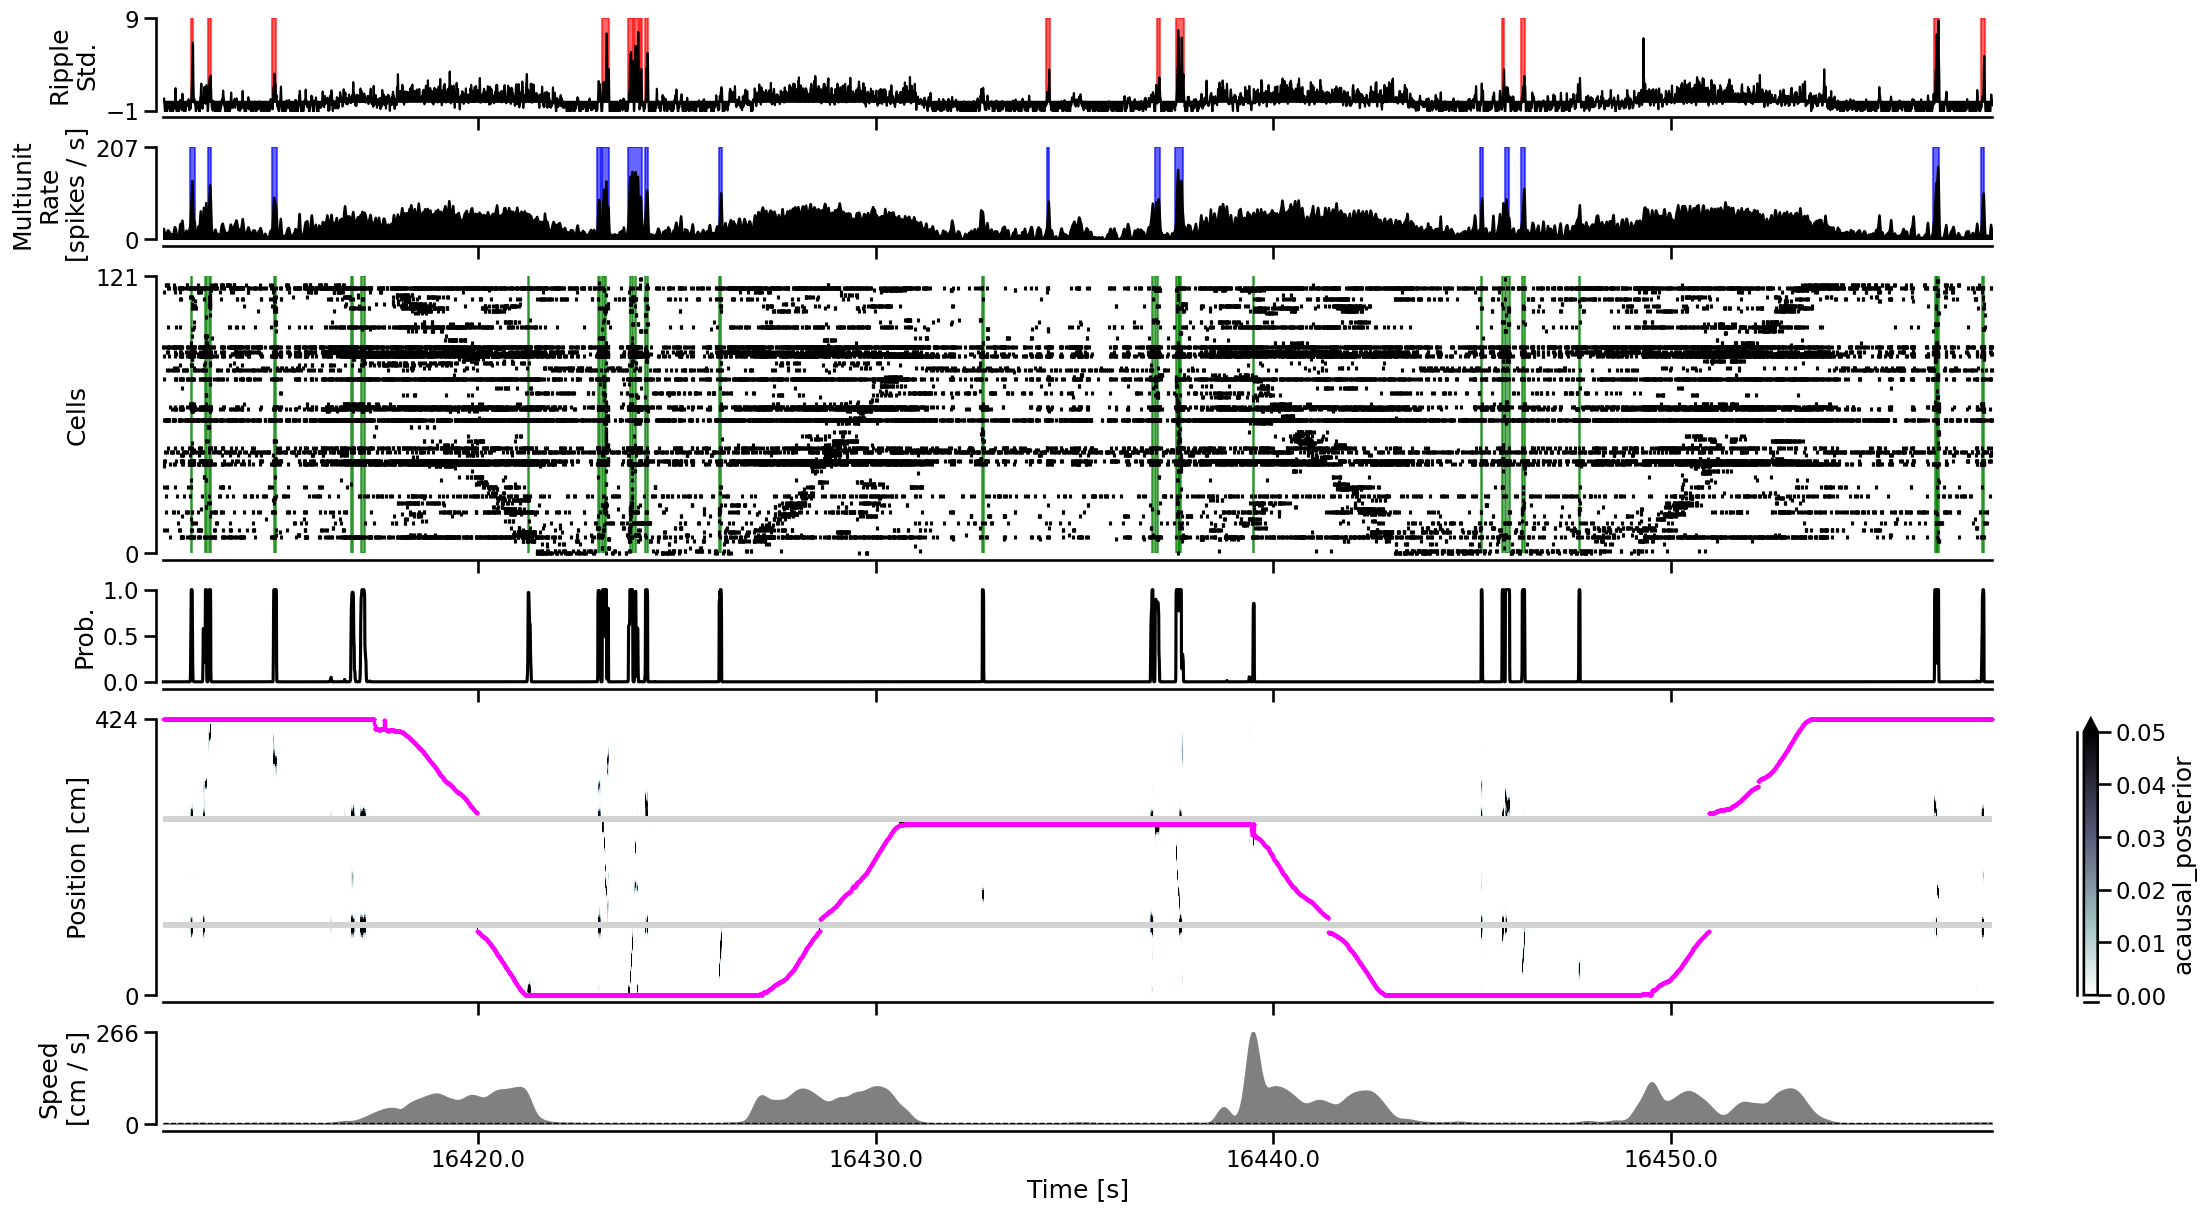

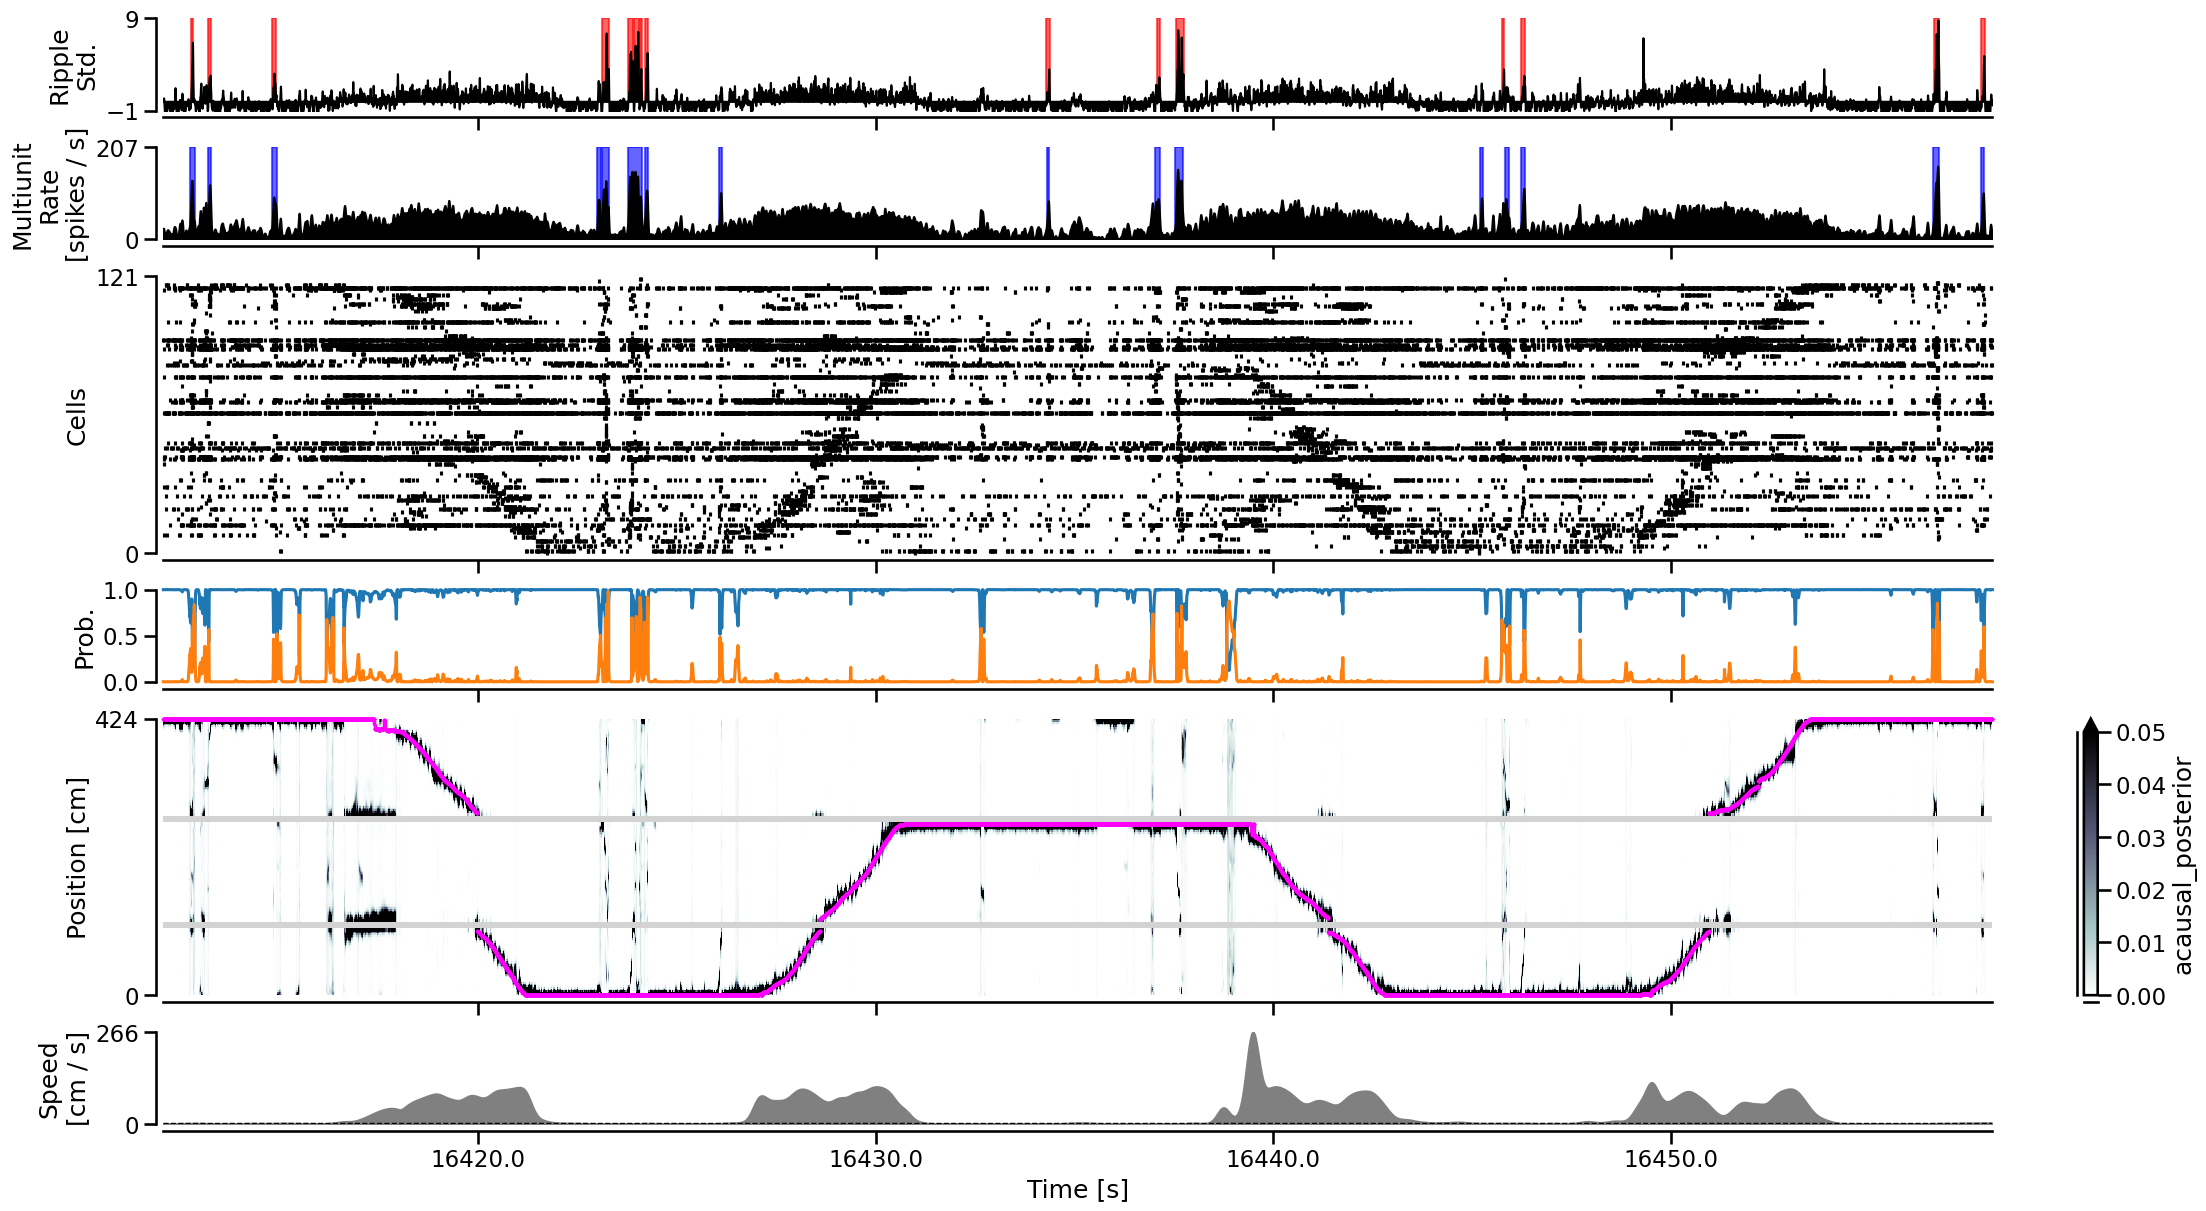

In [23]:
time_slice = slice(22_000, 45_000)
plot_detector(time_slice, data, replay_detector, results, figsize=(22, 12.0))
plot_classifier(time_slice, data, classifier, classifier_results, figsize=(22, 12.0))